## Todo
- chunk them out by 30 seconds to bootstrap and create more samples
- try some cross validation 
- test for overfitting
- more features 
    - get time signature from meta messages
    - ~~stdev of velocity (instead of just average)~~
    - create some manual cross variables with timing and key and time sig
    - frequency domain features

## Initial Imports and Paths

In [1]:
from composer_class_funcs import *

In [2]:
# ml packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

In [3]:
# file paths
train_midi_path = "./Challenge_DataSet/PS1/"
test_midi_path = "./Challenge_DataSet/PS2/"

## Data Collection and Processing

In [4]:
file_path_ps2 = test_midi_path+"0.981087291054314_adj.mid"
file_path_ps1 = train_midi_path+"Bach/Cello Suite 3_BWV1009_2217_cs3-1pre.mid"
x = extract_features_from_midi(file_path_ps1, second_interval=[210,240])

In [5]:
features, labels = load_dataset(train_midi_path, labeled=True, segments=4)
df_labeled = create_dataframe(features, labels)

In [6]:
unlabeled_features = load_dataset(test_midi_path, labeled=False)
df_unlabeled=create_dataframe(unlabeled_features)

In [7]:
numeric_columns = df_labeled.select_dtypes(include=['float64', 'int64']).columns

## EDA

In [8]:
df_labeled.head()

,filename,type,tpb,key,average_velocity,variance_velocity,Note_0,Note_1,Note_2,Note_3,...,Note_119,Note_120,Note_121,Note_122,Note_123,Note_124,Note_125,Note_126,Note_127,composer
0,Piano Sonata No 20 in C minor_OP111_2532_ps32_...,1,384,Cm,96.794118,221.114475,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Beethoven
1,Piano Sonata No 20 in C minor_OP111_2532_ps32_...,1,384,Cm,80.576923,212.881445,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Beethoven
2,Piano Sonata No 20 in C minor_OP111_2532_ps32_...,1,384,Cm,87.045198,225.094002,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Beethoven
3,Piano Sonata No 20 in C minor_OP111_2532_ps32_...,1,384,Cm,95.285024,175.498471,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Beethoven
4,Piano Sonata No 17 in D minor_OP31NO2_2391_ps1...,1,384,Dm,91.726708,175.391150,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Beethoven


In [9]:
df_unlabeled.head()

,filename,type,tpb,key,average_velocity,variance_velocity,Note_0,Note_1,Note_2,Note_3,...,Note_118,Note_119,Note_120,Note_121,Note_122,Note_123,Note_124,Note_125,Note_126,Note_127
0,0.8014751784512073_adj.mid,1,192,F,75.930435,187.082117,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.981087291054314_adj.mid,1,96,Eb,69.800000,22.589630,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.5807329043589801_adj.mid,1,120,C,54.280105,604.468662,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.23120017256495873_adj.mid,1,384,A,77.157303,261.177503,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.033313986422223163_adj.mid,1,384,Bm,100.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# Display basic information about the DataFrame
print("\nBasic Information about the DataFrame:")
print(df_labeled.info())

# Generate summary statistics
print("\nSummary Statistics of the DataFrame:")
print(df_labeled.describe())

# Check for missing values
print("\nMissing Values in the DataFrame:")
print(df_labeled.isnull().sum())


Basic Information about the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776 entries, 0 to 775
Columns: 135 entries, filename to composer
dtypes: float64(130), int64(2), object(3)
memory usage: 818.6+ KB
None

Summary Statistics of the DataFrame:
        type          tpb  average_velocity  variance_velocity  Note_0  \
count  776.0   776.000000        776.000000         776.000000   776.0   
mean     1.0   349.567010         80.592067         175.042063     0.0   
std      0.0   129.619505         15.324991         185.708051     0.0   
min      1.0   120.000000         36.000000           0.000000     0.0   
25%      1.0   384.000000         70.332868          27.579599     0.0   
50%      1.0   384.000000         81.389757         138.263244     0.0   
75%      1.0   384.000000         91.440289         238.879137     0.0   
max      1.0  1024.000000        127.000000        1081.281516     0.0   

       Note_1  Note_2  Note_3  Note_4  Note_5  ...  Note_118  Note_11

In [11]:
# confirm they're all type 1: 
## https://mido.readthedocs.io/en/latest/files/midi.html#file-types
## type 1 (synchronous): all tracks start at the same time
print(df_labeled.type.value_counts())
print(df_unlabeled.type.value_counts())

type
1    776
Name: count, dtype: int64
type
1    35
Name: count, dtype: int64


In [12]:
df_labeled.key.value_counts()

key
C      112
Eb     100
        64
G       60
F       60
Ab      60
Bb      56
E       56
A       48
D       40
Cm      32
Fm      20
Dm      16
Bm      12
Am       8
Db       8
Gb       8
Gm       4
Em       4
Abm      4
F#       4
Name: count, dtype: int64

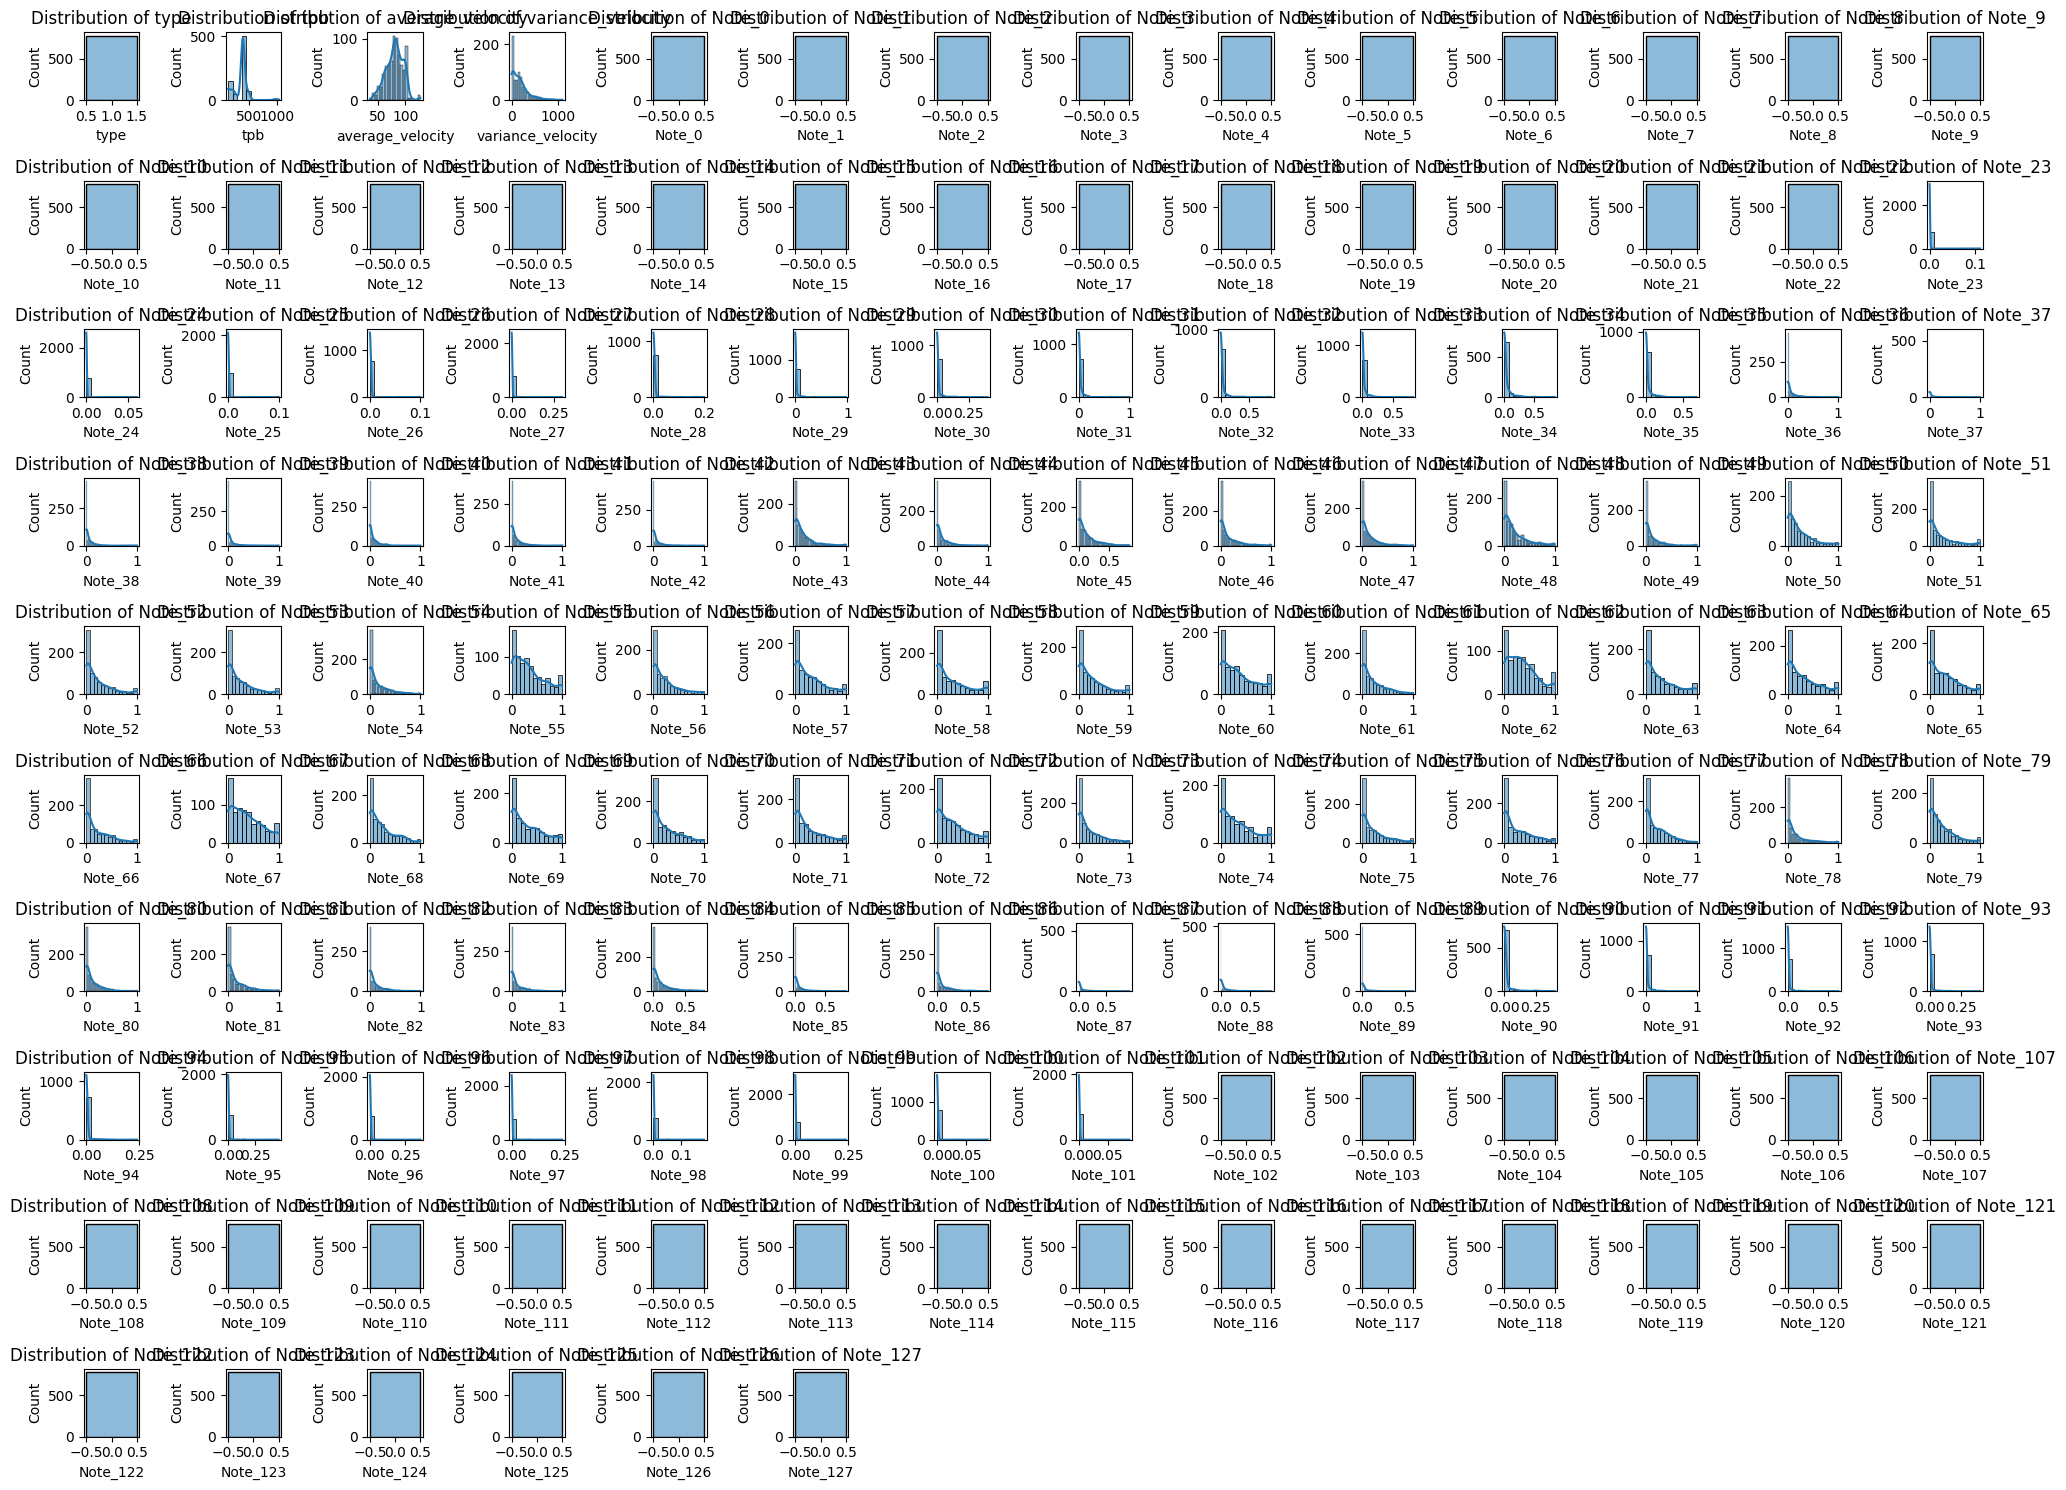

In [13]:
# Visualize the distribution of each numeric feature
# numeric_columns = df_labeled.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_columns):
    plt.subplot(10, 14, i+1)
    sns.histplot(df_labeled[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

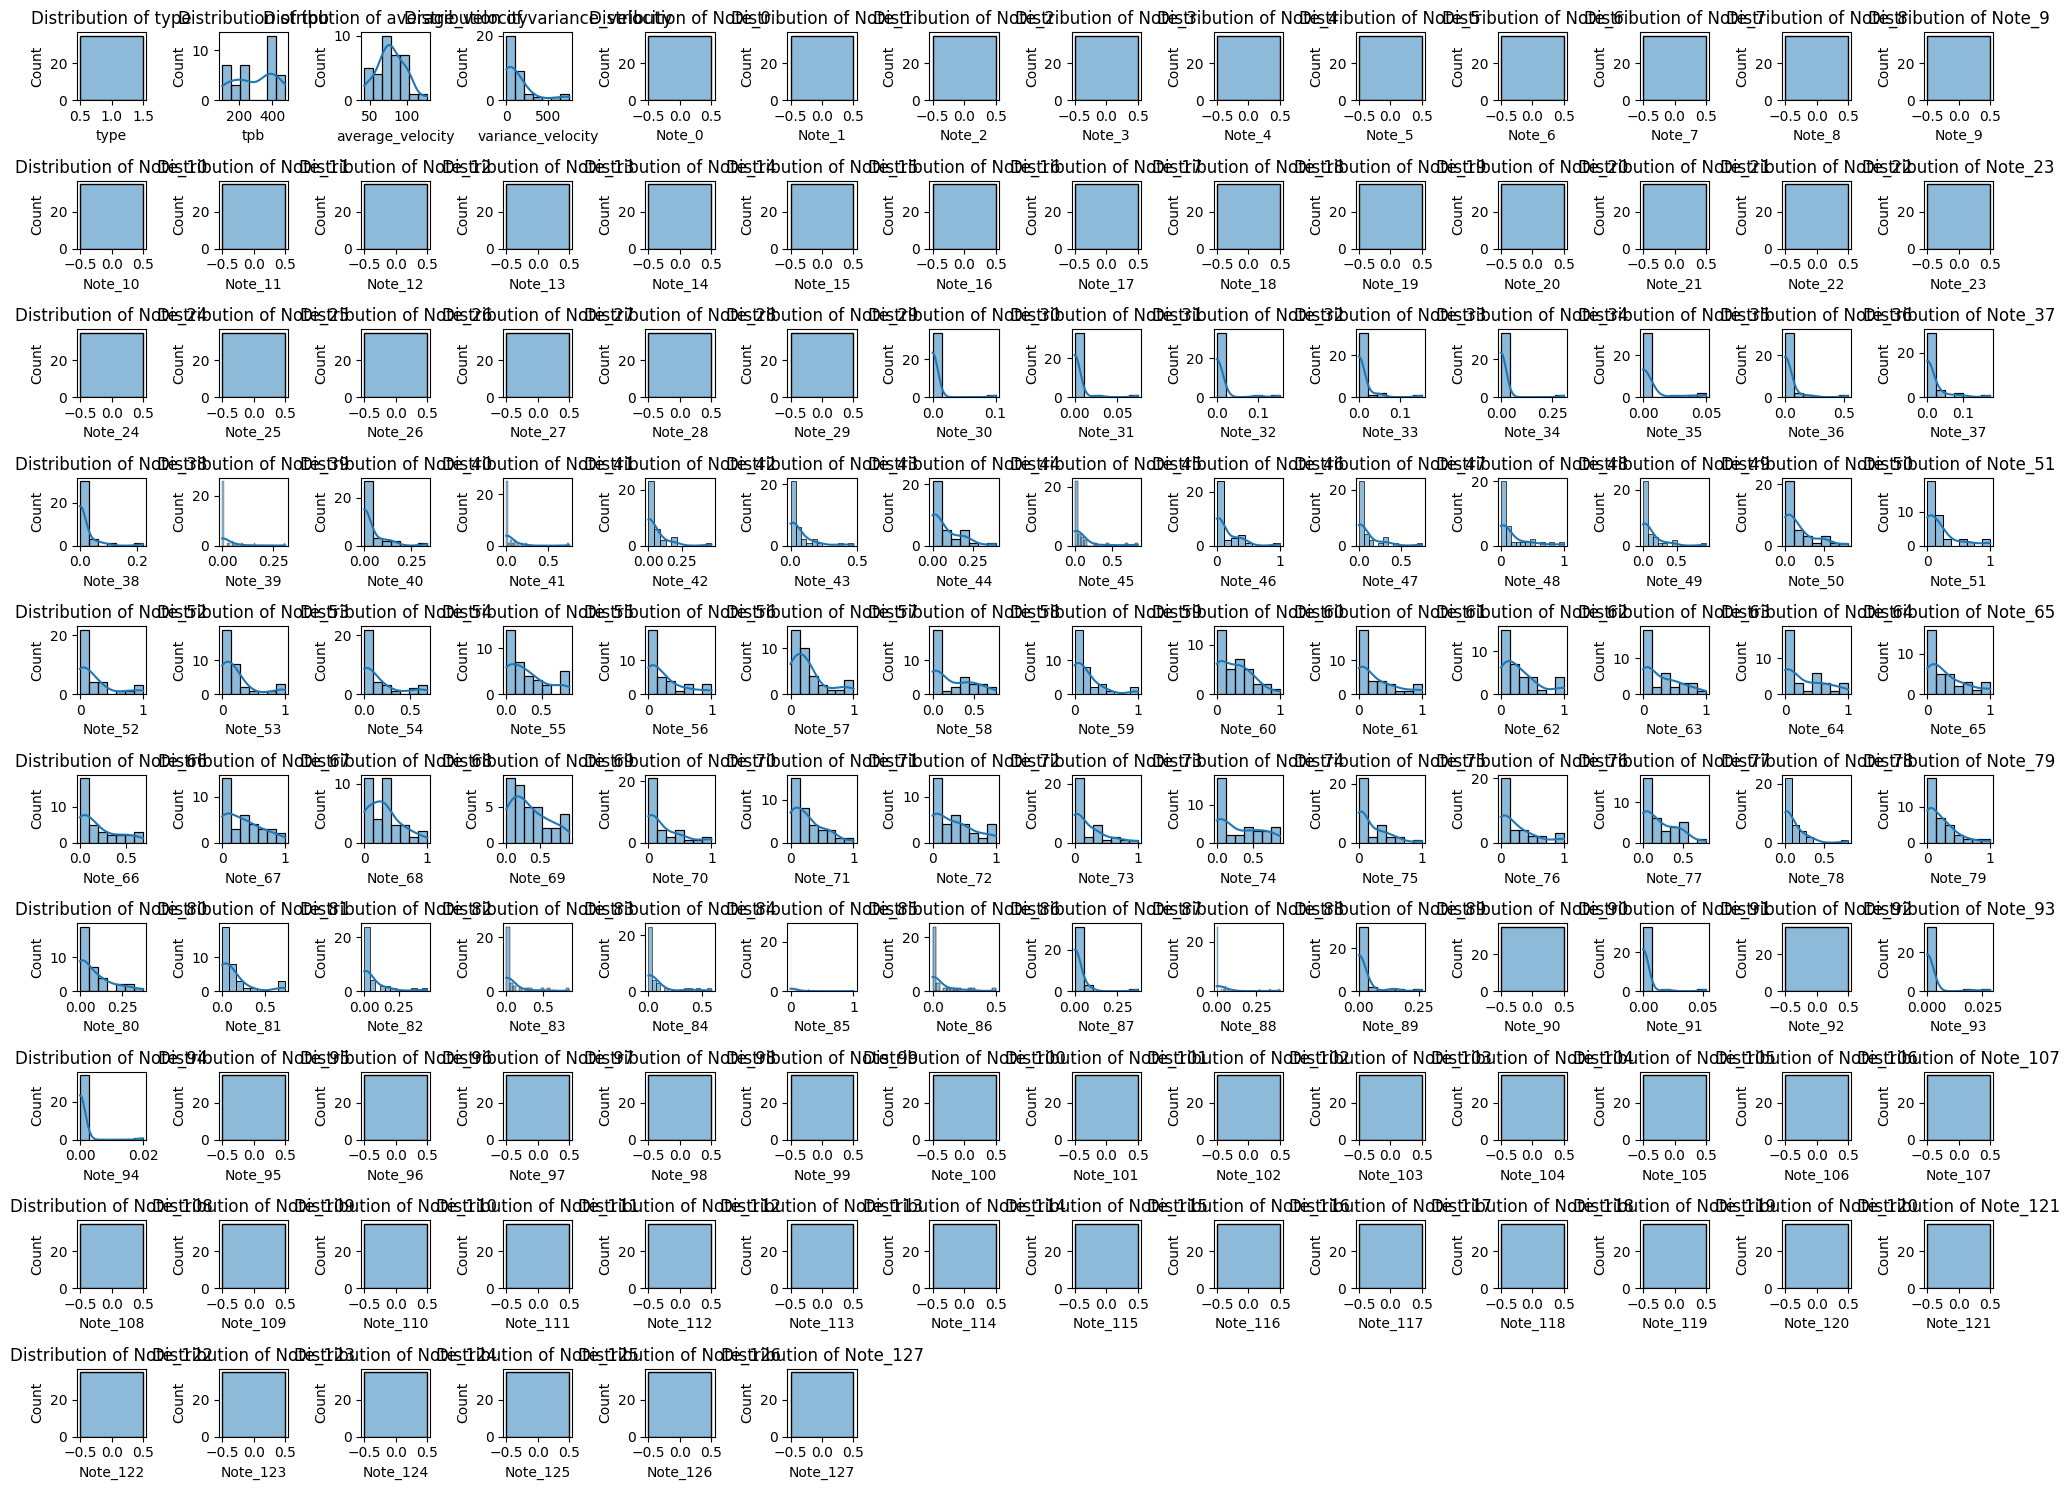

In [14]:
# Visualize the distribution of each numeric feature
# numeric_columns = df_unlabeled.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_columns):
    plt.subplot(10, 14, i+1)
    sns.histplot(df_unlabeled[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

based on this, I'd remove notes 0-22, 105-127.
The unlabeled dataset also has no info for these notes.
See feature engineering and prep section for removal

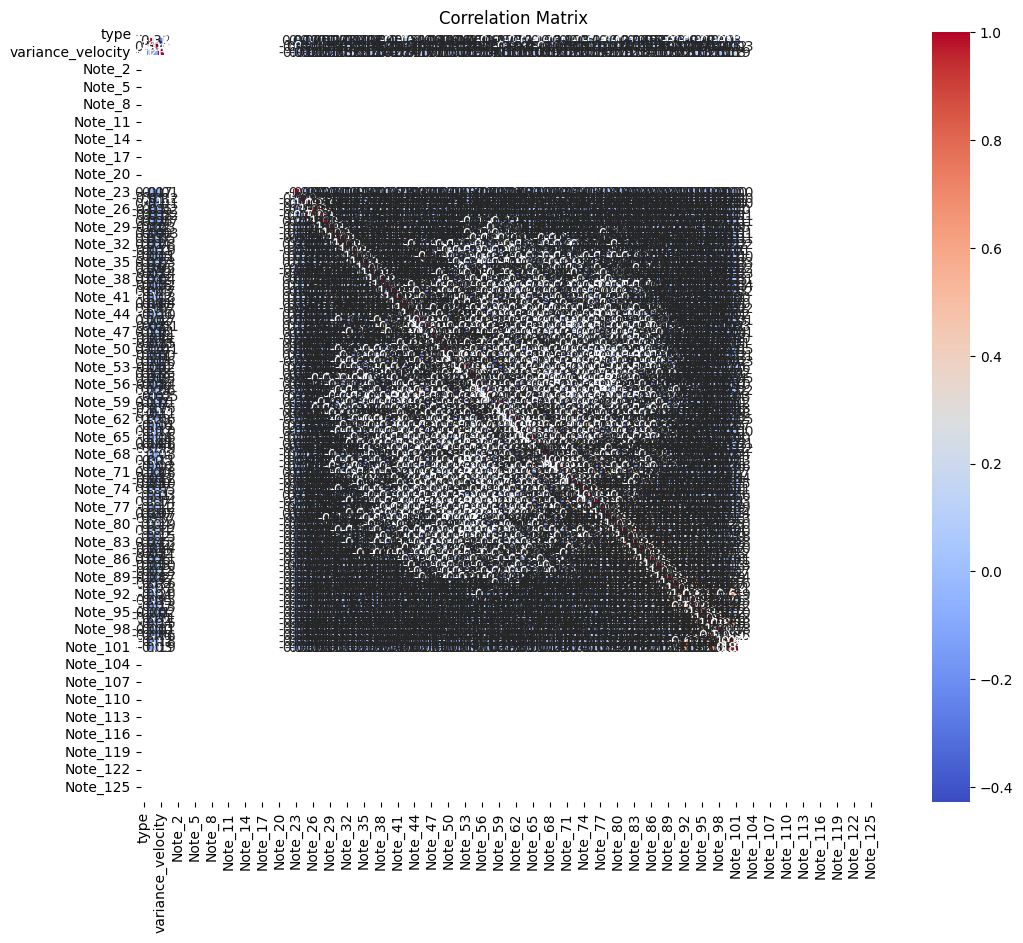

In [15]:
# Visualize correlations between numeric features
plt.figure(figsize=(12, 10))
correlation_matrix = df_labeled[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

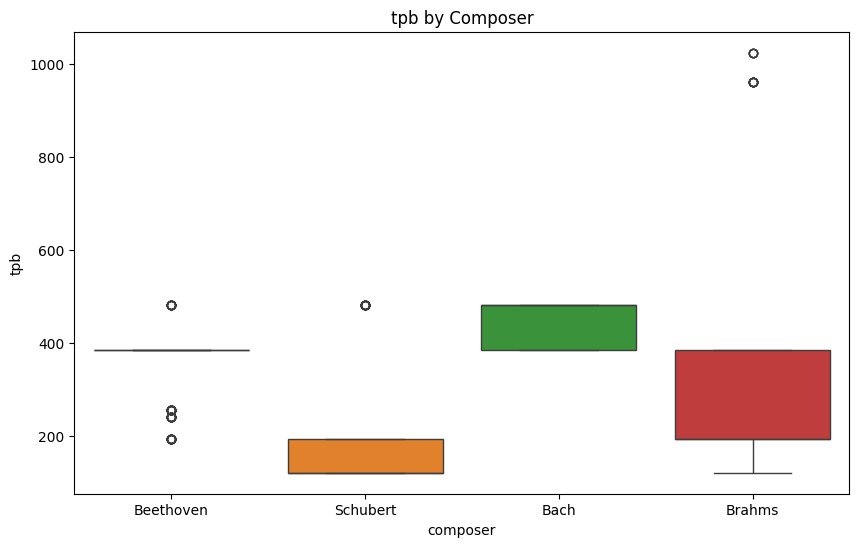

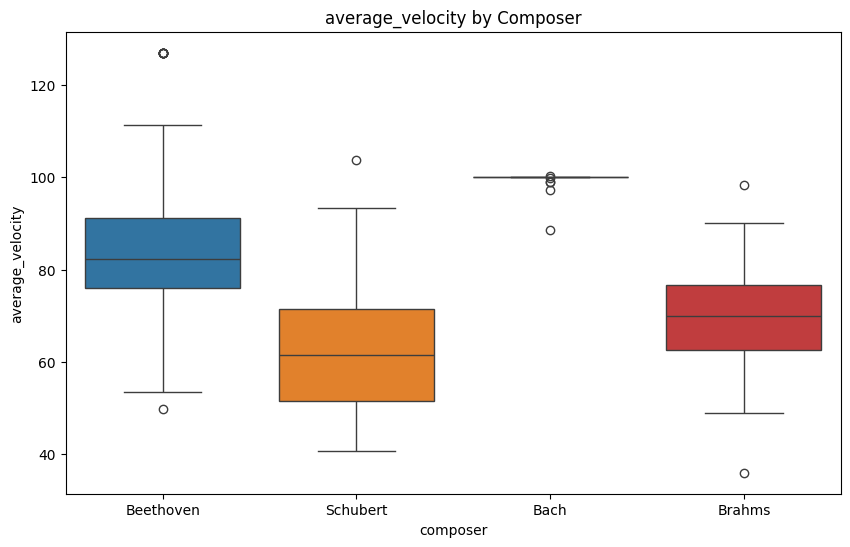

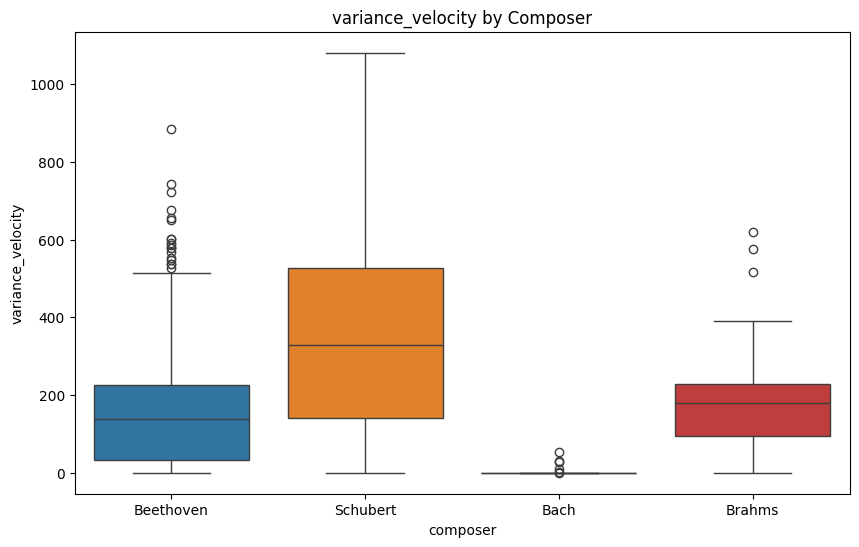

In [16]:
# Visualize the relationship between the first two numeric features and the target (if applicable)
if 'composer' in df_labeled.columns:
    for i in range(1,4):
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='composer', y=numeric_columns[i], data=df_labeled, hue='composer')
        plt.title(f'{numeric_columns[i]} by Composer')
        plt.show()

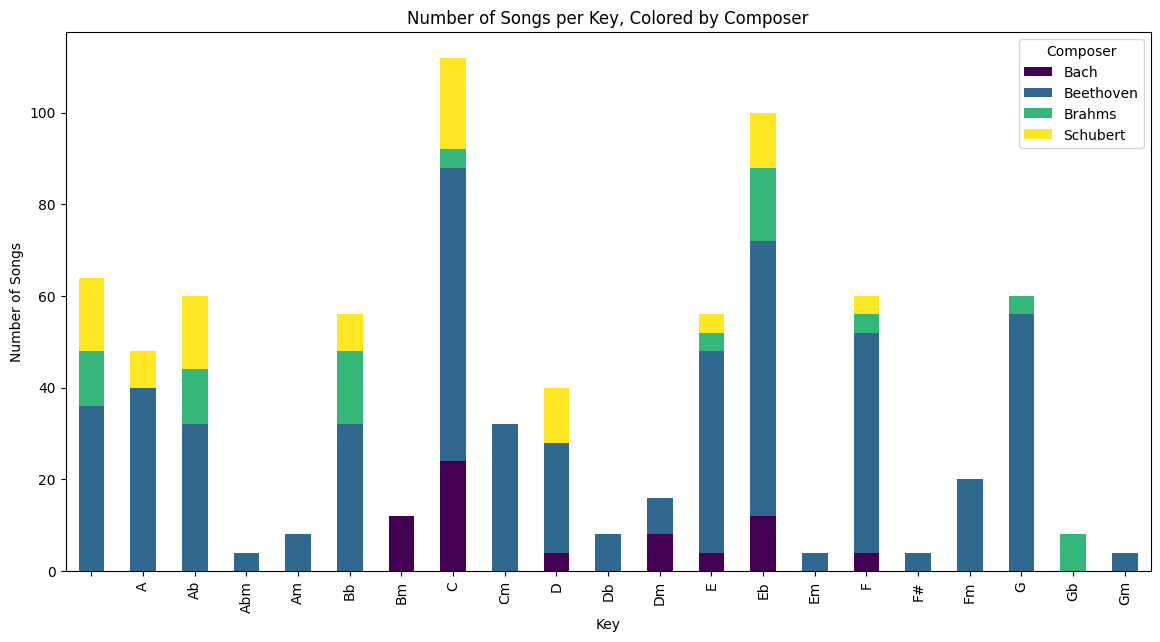

In [17]:
# Prepare the data for the stacked bar chart
key_composer_counts = df_labeled.groupby(['key', 'composer']).size().unstack(fill_value=0)
# Plot the stacked bar chart
key_composer_counts.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='viridis')
plt.title('Number of Songs per Key, Colored by Composer')
plt.xlabel('Key')
plt.ylabel('Number of Songs')
plt.xticks(rotation=90)
plt.legend(title='Composer')
plt.show()

## Clean + Feature engineer

In [18]:
# Drop columns corresponding to notes 0-22 and 105-127
cols_to_drop = [f'Note_{i}' for i in list(range(0, 23)) + list(range(105, 128))]
df_labeled.drop(columns=cols_to_drop, inplace=True)
df_unlabeled.drop(columns=cols_to_drop, inplace=True)

In [19]:
# replace Null keys with 'unk' value
df_labeled['key']=df_labeled['key'].fillna('unk')
df_unlabeled['key']=df_unlabeled['key'].fillna('unk')

# Encode the 'key' variable
label_encoder_key = LabelEncoder()
label_encoder_key.fit(df_labeled['key'].unique().tolist()+df_unlabeled['key'].unique().tolist())
df_labeled['key_encoded'] = label_encoder_key.transform(df_labeled['key'])
df_unlabeled['key_encoded'] = label_encoder_key.transform(df_unlabeled['key'])

# Encode the 'Composer' column
label_encoder_composer = LabelEncoder()
df_labeled['composer'] = label_encoder_composer.fit_transform(df_labeled['composer'])

In [20]:
# Define the features (X) and target (y)
X = df_labeled.drop(columns=['composer', 'filename','key'])
y = df_labeled['composer']

# Define features for unlabeled data
z = df_unlabeled.drop(columns=['filename','key'])

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [22]:
print(label_encoder_composer.classes_,'\n')
print('train targets\n',y_train.value_counts())
print('\ntest targets\n',y_test.value_counts())

['Bach' 'Beethoven' 'Brahms' 'Schubert'] 

train targets
 composer
1    313
3     62
2     47
0     43
Name: count, dtype: int64

test targets
 composer
1    215
3     38
2     33
0     25
Name: count, dtype: int64


## Train Classifiers

### Logistic Regression

In [23]:
# Train and evaluate the Logistic Regression model
log_reg = LogisticRegression(max_iter=10000, random_state=42)
log_reg.fit(X_train, y_train)
# predictions
y_pred_test_lr = log_reg.predict(X_test)
y_pred_train_lr = log_reg.predict(X_train)
# Get the classification probabilities for each class for test dataset
y_proba_test_lr = log_reg.predict_proba(X_test)
y_proba_train_lr = log_reg.predict_proba(X_train)

/Users/bartmasters/code/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression :
AUC for Training Set: 0.9645
AUC for Test Set: 0.9262
Accuracy Score (Test): 0.8456591639871383

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        25
           1       0.89      0.96      0.92       215
           2       0.50      0.27      0.35        33
           3       0.72      0.68      0.70        38

    accuracy                           0.85       311
   macro avg       0.75      0.70      0.71       311
weighted avg       0.83      0.85      0.83       311



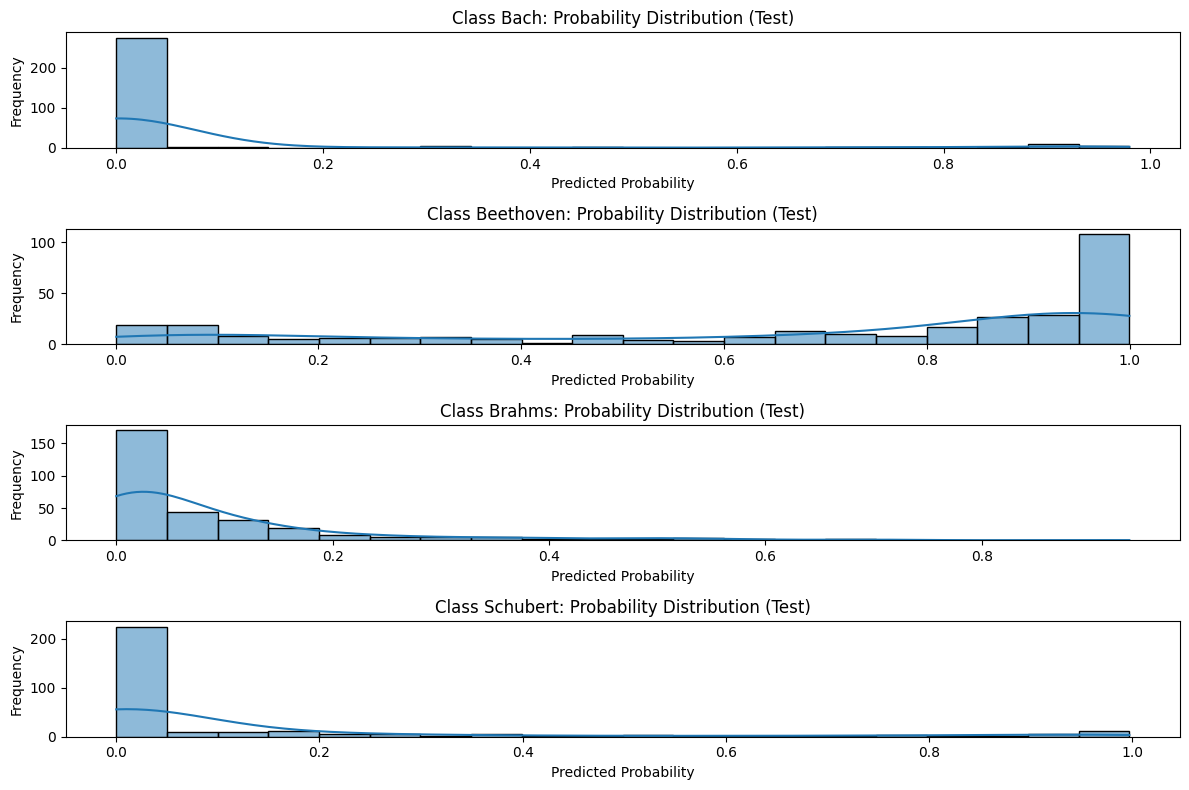

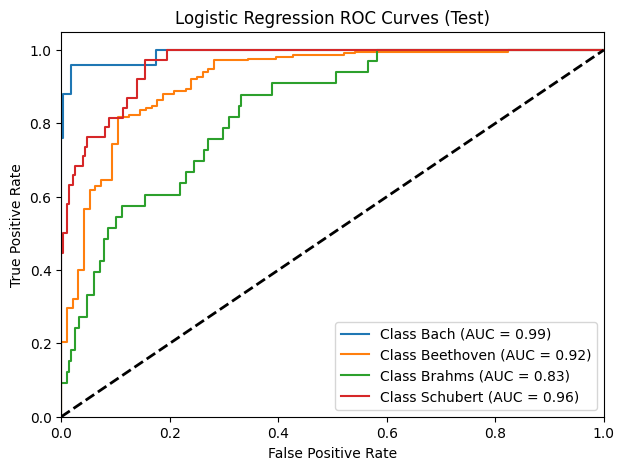

In [24]:
model_eval("Logistic Regression", y_train, y_pred_train_lr, y_proba_train_lr, y_test, y_pred_test_lr, y_proba_test_lr, label_encoder_composer)

In [25]:
# model_eval("Logistic Regression", y_test, y_pred_test_lr, y_proba_lr, label_encoder_composer)

### SVM

In [26]:
# Build and train the Random Forest classifier
svm_classifier = LinearSVC(penalty='l2', random_state=0, tol=1e-5)
# Wrap the LinearSVC classifier with CalibratedClassifierCV to obtain probabilities
calibrated_svc = CalibratedClassifierCV(estimator=svm_classifier, method='sigmoid')
calibrated_svc.fit(X_train, y_train)
# predictions
y_pred_test_svc = calibrated_svc.predict(X_test)
y_pred_train_svc = calibrated_svc.predict(X_train)
# Get the classification probabilities for each class for test dataset
y_proba_test_svc = calibrated_svc.predict_proba(X_test)
y_proba_train_svc = calibrated_svc.predict_proba(X_train)

Support Vector Machine (CV Calibrated) :
AUC for Training Set: 0.9613
AUC for Test Set: 0.8991
Accuracy Score (Test): 0.7652733118971061

Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      0.04      0.08        25
           1       0.76      1.00      0.86       215
           2       1.00      0.03      0.06        33
           3       0.85      0.58      0.69        38

    accuracy                           0.77       311
   macro avg       0.90      0.41      0.42       311
weighted avg       0.81      0.77      0.69       311



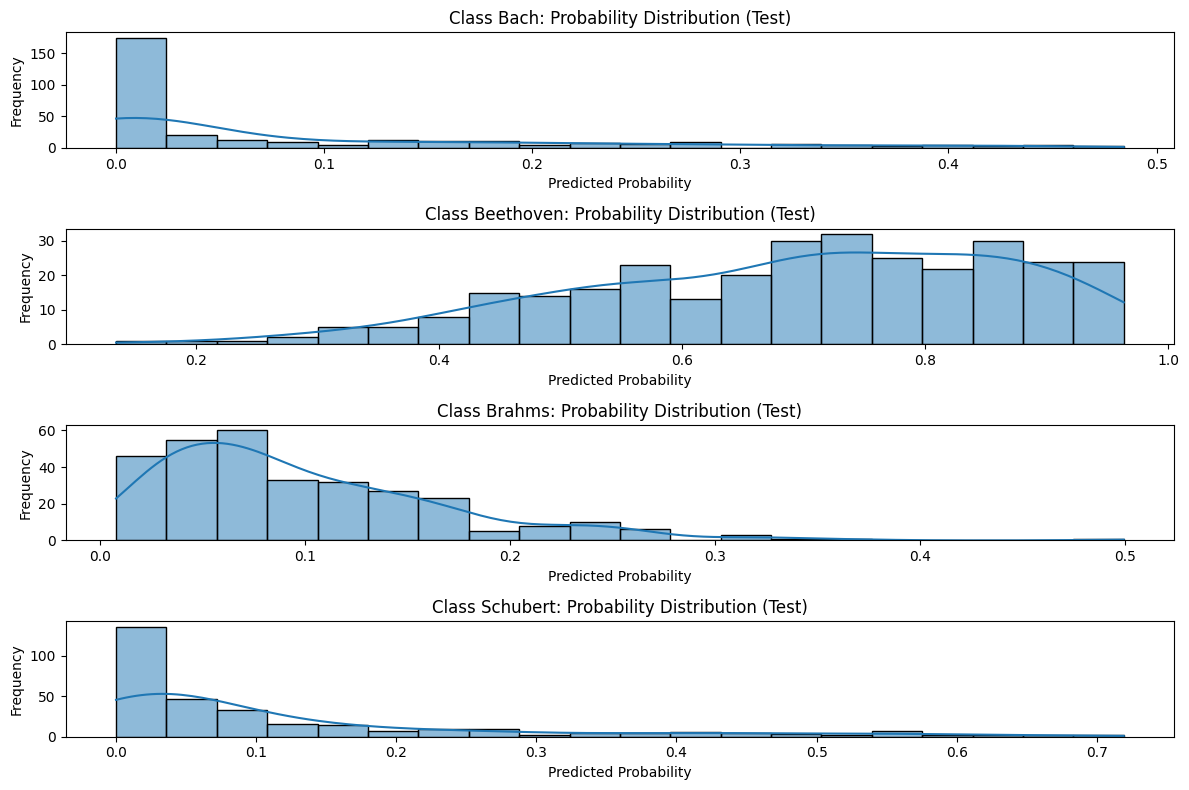

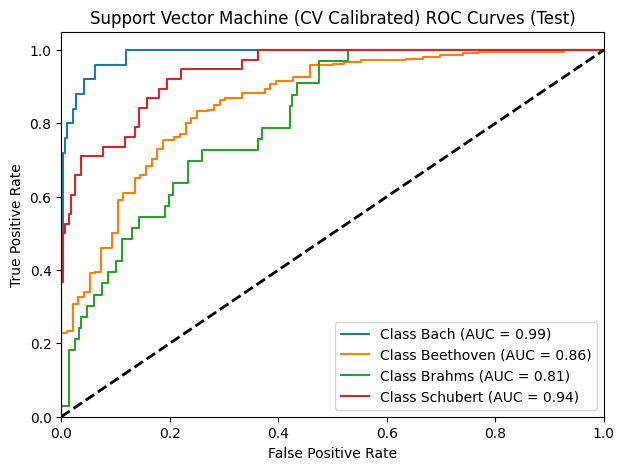

In [27]:
# model_eval("Support Vector Machine (CV Calibrated)", y_test, y_pred_svc, y_proba_svc, label_encoder_composer)
model_eval("Support Vector Machine (CV Calibrated)", y_train, y_pred_train_svc, y_proba_train_svc, y_test, y_pred_test_svc, y_proba_test_svc, label_encoder_composer)

### Random Forest

In [28]:
# Build and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
# predictions
y_pred_test_rf = rf_classifier.predict(X_test)
y_pred_train_rf = rf_classifier.predict(X_train)
# Get the classification probabilities for each class for test dataset
y_proba_test_rf = rf_classifier.predict_proba(X_test)
y_proba_train_rf = rf_classifier.predict_proba(X_train)

Random Forest :
AUC for Training Set: 1.0000
AUC for Test Set: 0.9817
Accuracy Score (Test): 0.9003215434083601

Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        25
           1       0.90      1.00      0.95       215
           2       0.92      0.33      0.49        33
           3       0.85      0.89      0.87        38

    accuracy                           0.90       311
   macro avg       0.92      0.76      0.80       311
weighted avg       0.90      0.90      0.88       311



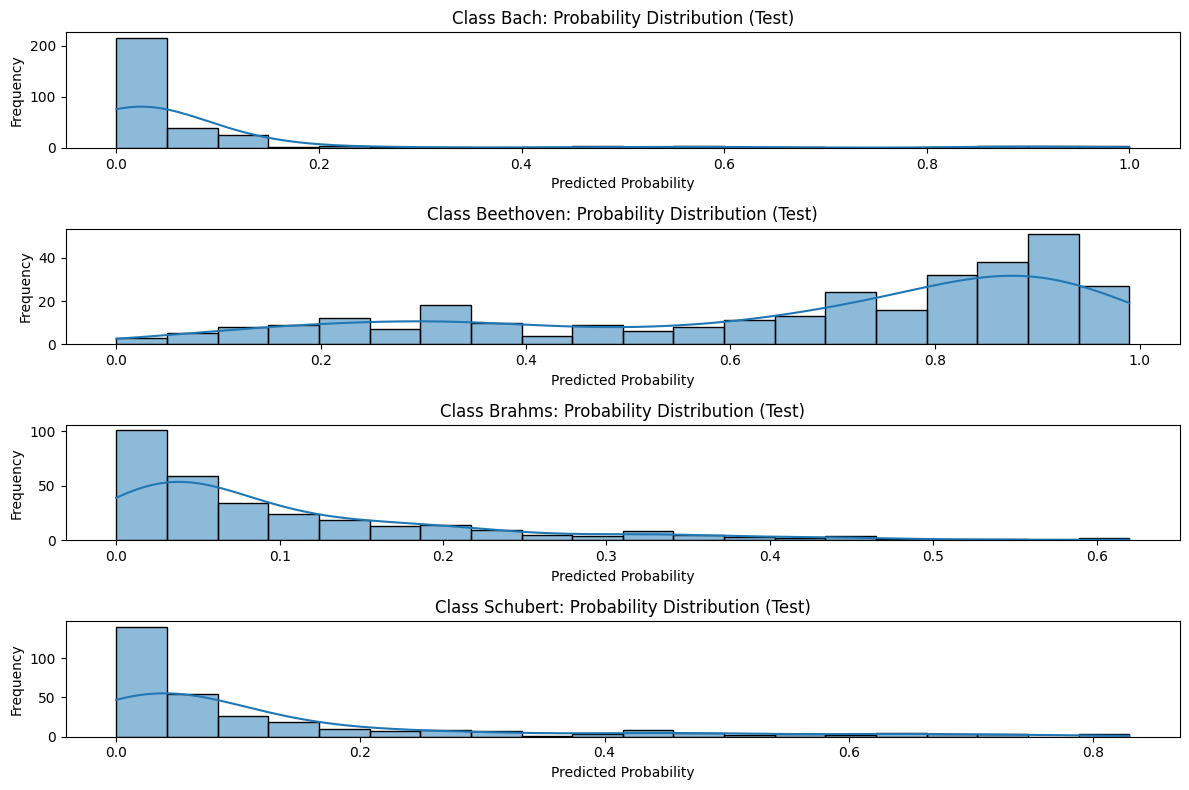

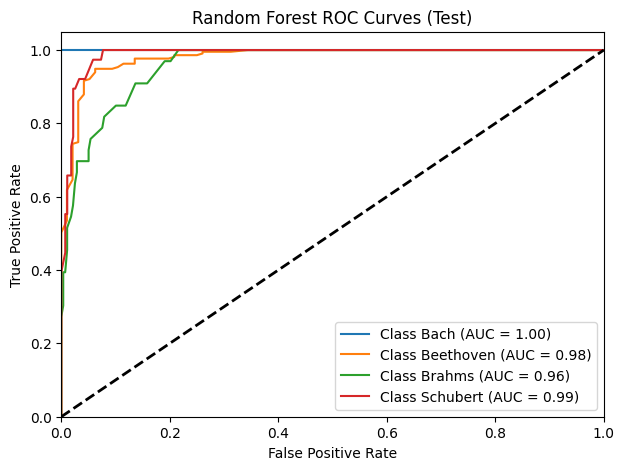

In [29]:
# model_eval("Random Forest", y_test, y_pred_rf, y_proba_rf, label_encoder_composer)
model_eval("Random Forest", y_train, y_pred_train_rf, y_proba_train_rf, y_test, y_pred_test_rf, y_proba_test_rf, label_encoder_composer)

### GBM

In [30]:
# Build and train the Random Forest classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_classifier.fit(X_train, y_train)

# predictions
y_pred_test_gb = gb_classifier.predict(X_test)
y_pred_train_gb = gb_classifier.predict(X_train)
# Get the classification probabilities for each class for test dataset
y_proba_test_gb = gb_classifier.predict_proba(X_test)
y_proba_train_gb = gb_classifier.predict_proba(X_train)

GBM :
AUC for Training Set: 1.0000
AUC for Test Set: 0.9509
Accuracy Score (Test): 0.8971061093247589

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.74      0.92      0.82        25
           1       0.95      0.93      0.94       215
           2       0.71      0.67      0.69        33
           3       0.89      0.87      0.88        38

    accuracy                           0.90       311
   macro avg       0.82      0.85      0.83       311
weighted avg       0.90      0.90      0.90       311



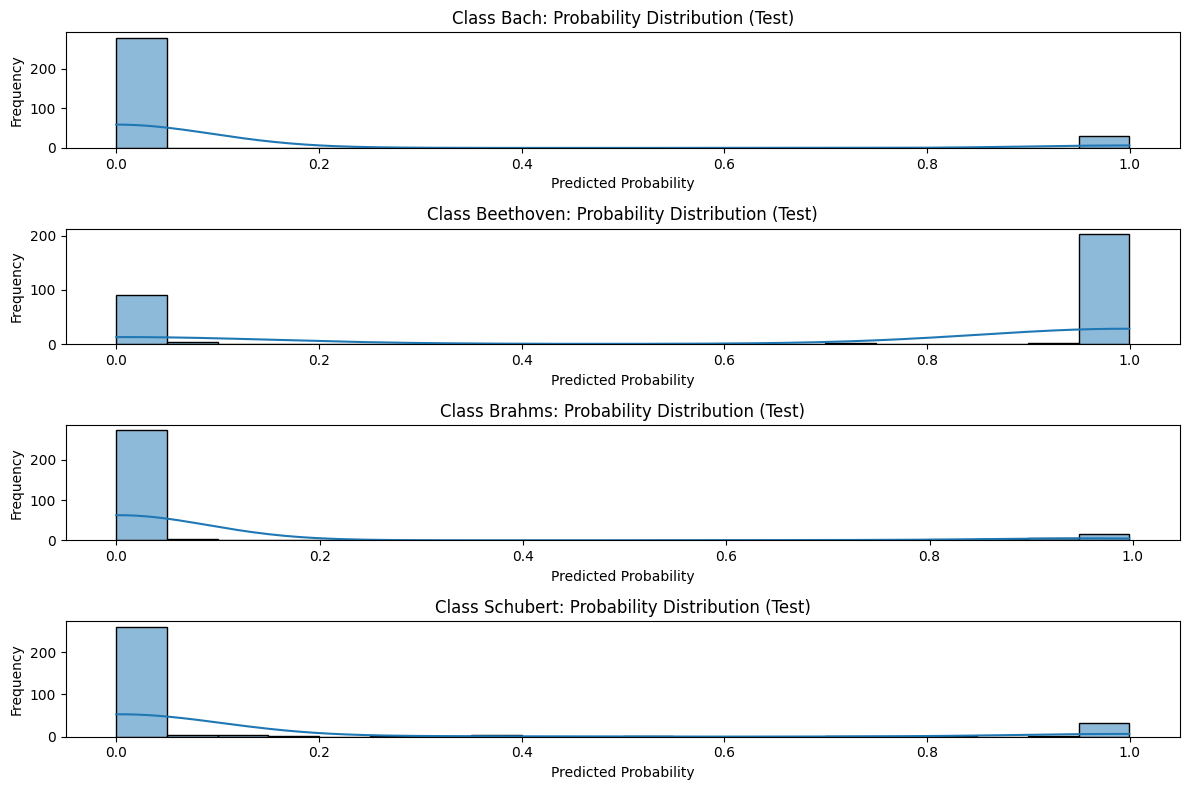

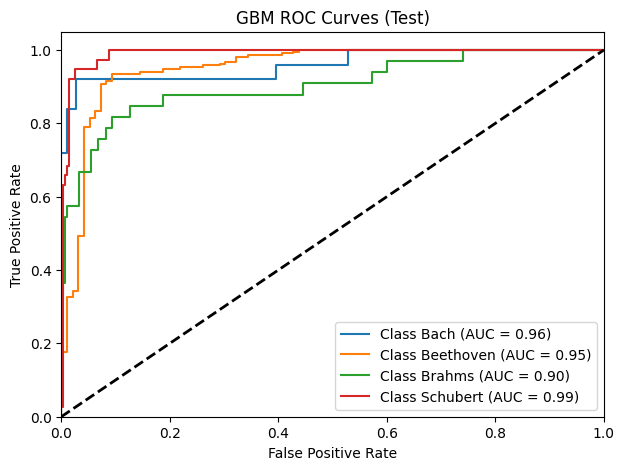

In [31]:
# model_eval("GBM", y_test, y_pred_gb, y_proba_gb, label_encoder_composer)
model_eval("GBM", y_train, y_pred_train_gb, y_proba_train_gb, y_test, y_pred_test_gb, y_proba_test_gb, label_encoder_composer)

## Inference: Unlabeled

In [32]:
# Predict the target on the test set
y_pred_unlabeled = gb_classifier.predict(z)
# Get the classification probabilities for each class
y_proba_unlabeled = gb_classifier.predict_proba(z)

In [33]:
print(y_pred_unlabeled)
print(label_encoder_composer.inverse_transform(y_pred_unlabeled))
# print(y_proba_unlabeled)

[2 3 3 1 0 2 1 1 1 1 1 1 3 0 1 0 1 2 0 3 0 1 0 1 3 1 1 1 1 3 1 1 3 1 1]
['Brahms' 'Schubert' 'Schubert' 'Beethoven' 'Bach' 'Brahms' 'Beethoven'
 'Beethoven' 'Beethoven' 'Beethoven' 'Beethoven' 'Beethoven' 'Schubert'
 'Bach' 'Beethoven' 'Bach' 'Beethoven' 'Brahms' 'Bach' 'Schubert' 'Bach'
 'Beethoven' 'Bach' 'Beethoven' 'Schubert' 'Beethoven' 'Beethoven'
 'Beethoven' 'Beethoven' 'Schubert' 'Beethoven' 'Beethoven' 'Schubert'
 'Beethoven' 'Beethoven']


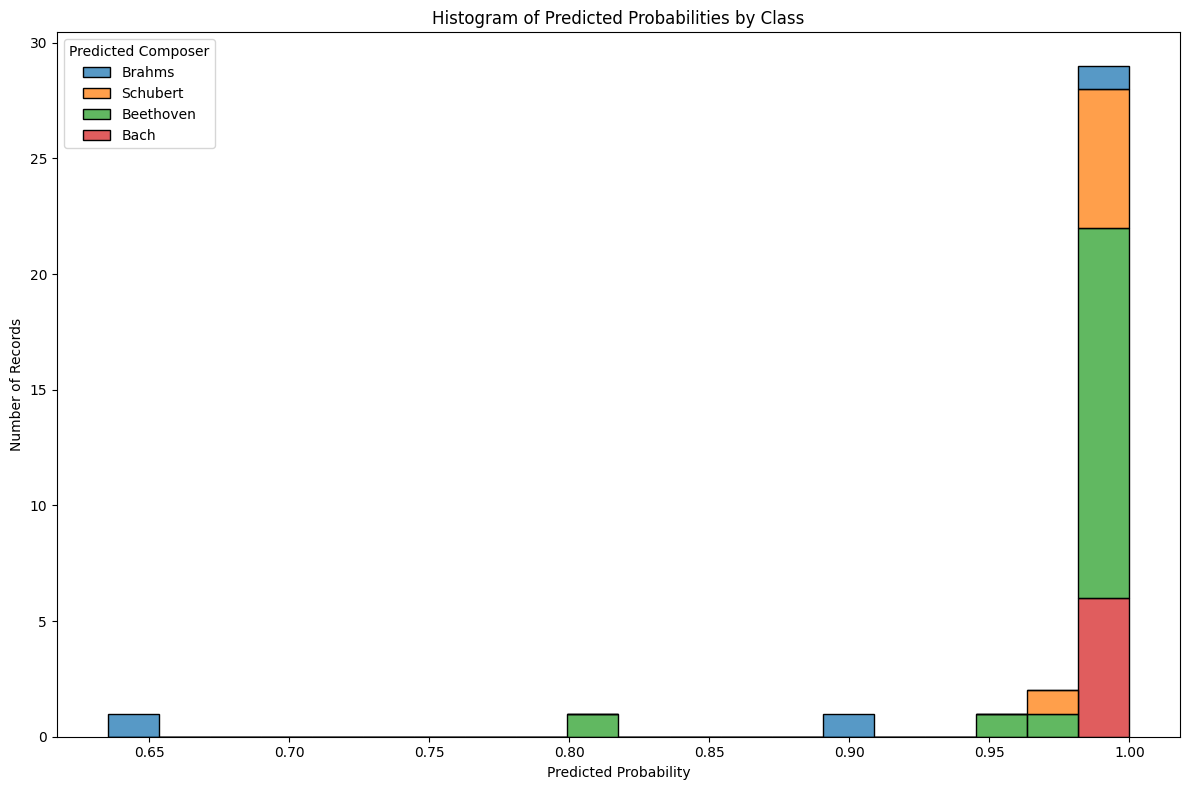

In [34]:
# Prepare the data for plotting
df_plot = pd.DataFrame(y_proba_unlabeled, columns=[f'Class_{i}_prob' for i in range(y_proba_unlabeled.shape[1])])
df_plot['Predicted_Class'] = y_pred_unlabeled
df_plot['Predicted Composer'] = label_encoder_composer.inverse_transform(y_pred_unlabeled)

# Extract the highest predicted probability for each record
df_plot['Max_Probability'] = df_plot[[f'Class_{i}_prob' for i in range(y_proba_unlabeled.shape[1])]].max(axis=1)

# Plot the histogram
plt.figure(figsize=(12, 8))
sns.histplot(data=df_plot, x='Max_Probability', hue='Predicted Composer', multiple='stack', palette='tab10', bins=20)
plt.title('Histogram of Predicted Probabilities by Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Number of Records')
plt.tight_layout()
plt.show()

Based on this histogram, we can select a probability threshold such that
```
if max(predicted probability for all classes) < threshold
then midi file is NOT one of the 4 composers in training data
````
To begin, I'd select a threshold of 0.90, resulting in 7 out of the 35 midi files being classified as NOT belonging to our 4 known composers.

In [38]:
df_unlabeled[['filename']].merge(df_plot[df_plot.Max_Probability<0.91],left_index=True, right_index=True, how = 'right').drop(
    labels=['Predicted_Class','Predicted Composer'], axis=1)

,filename,Class_0_prob,Class_1_prob,Class_2_prob,Class_3_prob,Max_Probability
0,0.8014751784512073_adj.mid,0.000420,0.092319,0.891989,0.015272,0.891989
5,0.3559970176888735_adj.mid,0.000120,0.353866,0.635271,0.010744,0.635271
28,0.1960551158929671_adj.mid,0.184102,0.804214,0.010197,0.001487,0.804214


### How we would operationalize/functionalize

# scratch

In [36]:
file_path_ps2 = test_midi_path+"0.981087291054314_adj.mid"
file_path_ps1 = train_midi_path+"Bach/Cello Suite 3_BWV1009_2217_cs3-1pre.mid"

In [37]:
x = extract_features_from_midi(file_path_ps1)